In [8]:
import pandas as pd
US_videos = pd.read_csv('USvideos.csv')
US_videos.shape
US_videos

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th..."
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo..."


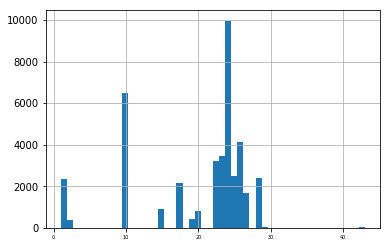

In [36]:
US_videos['category_id'].hist(bins= 50,grid=True,xlabelsize=5)

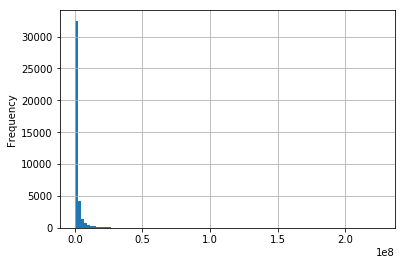

In [28]:
US_videos['views'].plot.hist(bins= 100,grid=True)